# Taller 2

1. Cree una función en Python que a partir de un conjunto de $n + 1$ datos, calcule el polinomio
de interpolación de Newton de grado $n$. Grafique el polinomio de interpolación junto con lo
datos experimetales aportados en el archivo "Datos Taller 2.txt" en el rango $[0, 6]$.

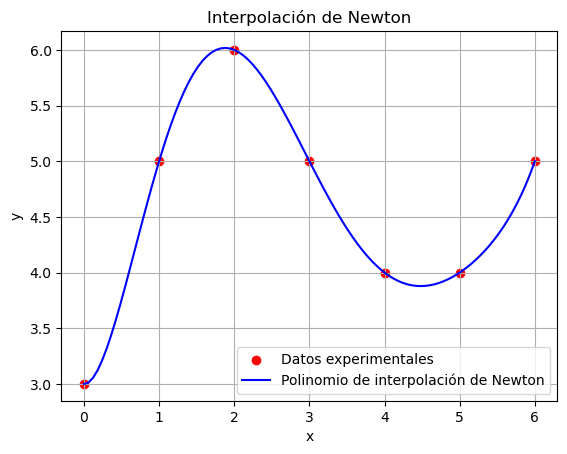

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def newton_divided_differences(x, y):
    """ Calcula las diferencias divididas de Newton."""
    n = len(x)
    coef = np.copy(y).astype(float)
    for j in range(1, n):
        for i in range(n - 1, j - 1, -1):
            coef[i] = (coef[i] - coef[i - 1]) / (x[i] - x[i - j])
    return coef

def newton_polynomial(x_data_n, coef, x):
    """ Evalúa el polinomio de interpolación de Newton en x."""
    n = len(x_data_n)
    result = coef[-1]
    for i in range(n - 2, -1, -1):
        result = result * (x - x_data_n[i]) + coef[i]
    return result

# Cargar los datos
data = np.loadtxt("Datos_Taller_2.txt")
x_data, y_data = data[:, 0], data[:, 1]

# Calcular coeficientes del polinomio de Newton
coef = newton_divided_differences(x_data, y_data)

# Puntos para la evaluación del polinomio
x_vals_n = np.linspace(0, 6, 100)
y_vals_n = newton_polynomial(x_data, coef, x_vals_n)

# Graficar
plt.scatter(x_data, y_data, color='red', label='Datos experimentales')
plt.plot(x_vals_n, y_vals_n, label='Polinomio de interpolación de Newton', color='blue')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Interpolación de Newton')
plt.grid()
plt.show()

2. Cree una función en Python que a partir de un conjunto de $n + 1$ datos, calcule el polinomio
de interpolación de Lagrange de grado $n$. Grafique el polinomio de interpolación junto con lo
datos experimetales aportados en el archivo "Datos Taller 2.txt" en el rango $[0, 6]$.

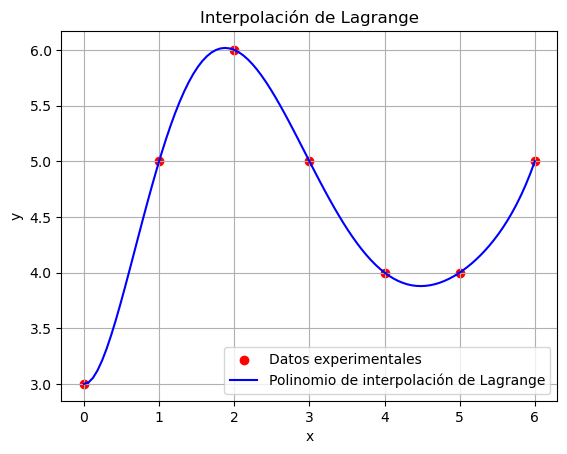

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def lagrange_basis(x, x_data_l, k):
    """ Calcula la base de Lagrange L_k(x). """
    basis = 1
    for i in range(len(x_data_l)):
        if i != k:
            basis *= (x - x_data_l[i]) / (x_data_l[k] - x_data_l[i])
    return basis

def lagrange_interpolation(x_data_l, y_data_l, x):
    """ Calcula el polinomio de interpolación de Lagrange en x. """
    n = len(x_data_l)
    result = 0
    for k in range(n):
        result += y_data_l[k] * lagrange_basis(x, x_data_l, k)
    return result

# Cargar los datos
data = np.loadtxt("Datos_Taller_2.txt")
x_data, y_data = data[:, 0], data[:, 1]

# Puntos para la evaluación del polinomio
x_vals_l = np.linspace(0, 6, 100)
y_vals_l = [lagrange_interpolation(x_data, y_data, x) for x in x_vals_l]

# Graficar
plt.scatter(x_data, y_data, color='red', label='Datos experimentales')
plt.plot(x_vals_l, y_vals_l, label='Polinomio de interpolación de Lagrange', color='blue')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Interpolación de Lagrange')
plt.grid()
plt.show()

3. Cree una función en Python que a partir de un conjunto de $n + 1$ datos, calcule el polinomio
de interpolación a través de splines cúbicos. Grafique el polinomio de interpolación junto con
lo datos experimetales aportados en el archivo "Datos Taller 2.txt" en el rango $[0, 6]$.

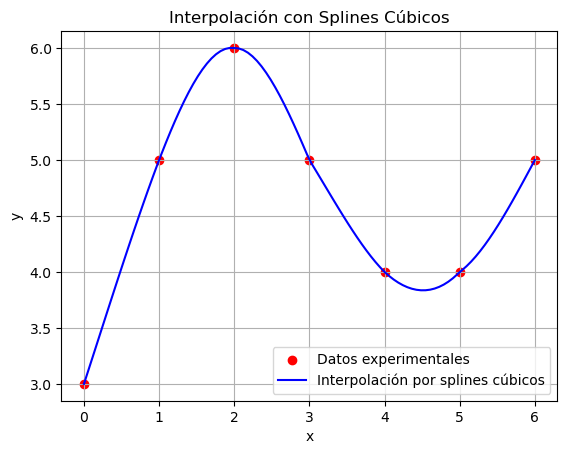

In [19]:
import numpy as np
import matplotlib.pyplot as plt

def tridiagonal_solve(a, b, c, d):
    """Resuelve un sistema tridiagonal Ax = d usando eliminación de Gauss."""
    n = len(d)
    c_ = np.zeros(n-1)
    d_ = np.zeros(n)
    
    c_[0] = c[0] / b[0]
    d_[0] = d[0] / b[0]
    
    for i in range(1, n-1):
        denom = b[i] - a[i-1] * c_[i-1]
        c_[i] = c[i] / denom
        d_[i] = (d[i] - a[i-1] * d_[i-1]) / denom
    
    d_[-1] = (d[-1] - a[-2] * d_[-2]) / (b[-1] - a[-2] * c_[-2])
    
    x = np.zeros(n)
    x[-1] = d_[-1]
    for i in range(n-2, -1, -1):
        x[i] = d_[i] - c_[i] * x[i+1]
    
    return x

def cubic_spline(x_data, y_data):
    """Calcula los coeficientes del spline cúbico."""
    n = len(x_data) - 1
    h = np.diff(x_data)
    alpha = np.zeros(n-1)
    for i in range(1, n):
        alpha[i-1] = (3/h[i] * (y_data[i+1] - y_data[i]) - 3/h[i-1] * (y_data[i] - y_data[i-1]))
    
    l = np.ones(n+1)
    mu = np.zeros(n)
    z = np.zeros(n+1)
    
    l[1:n] = 2 * (x_data[2:n+1] - x_data[0:n-1]) - h[0:n-1] * mu[0:n-1]
    mu[0:n-1] = h[1:n] / l[1:n]
    z[1:n] = (alpha - h[0:n-1] * z[0:n-1]) / l[1:n]
    
    b = np.zeros(n)
    c = np.zeros(n+1)
    d = np.zeros(n)
    c[n] = 0
    
    for j in range(n-1, -1, -1):
        c[j] = z[j] - mu[j] * c[j+1]
        b[j] = (y_data[j+1] - y_data[j]) / h[j] - h[j] * (c[j+1] + 2 * c[j]) / 3
        d[j] = (c[j+1] - c[j]) / (3 * h[j])
    
    return y_data[:-1], b, c[:-1], d

def evaluate_spline(x_data, coef, x_vals):
    """Evalúa el spline cúbico en los puntos x_vals."""
    y_data, b, c, d = coef
    y_vals = np.zeros_like(x_vals)
    
    for i in range(len(x_data) - 1):
        idx = np.where((x_vals >= x_data[i]) & (x_vals <= x_data[i+1]))
        dx = x_vals[idx] - x_data[i]
        y_vals[idx] = y_data[i] + b[i] * dx + c[i] * dx**2 + d[i] * dx**3
    
    return y_vals

# Cargar los datos
data = np.loadtxt("Datos_Taller_2.txt")
x_data, y_data = data[:, 0], data[:, 1]

# Calcular coeficientes del spline cúbico
coef = cubic_spline(x_data, y_data)

# Puntos para la evaluación del spline
x_vals = np.linspace(0, 6, 100)
y_vals = evaluate_spline(x_data, coef, x_vals)

# Graficar
plt.scatter(x_data, y_data, color='red', label='Datos experimentales')
plt.plot(x_vals, y_vals, label='Interpolación por splines cúbicos', color='blue')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Interpolación con Splines Cúbicos')
plt.grid()
plt.show()

## Lagrange

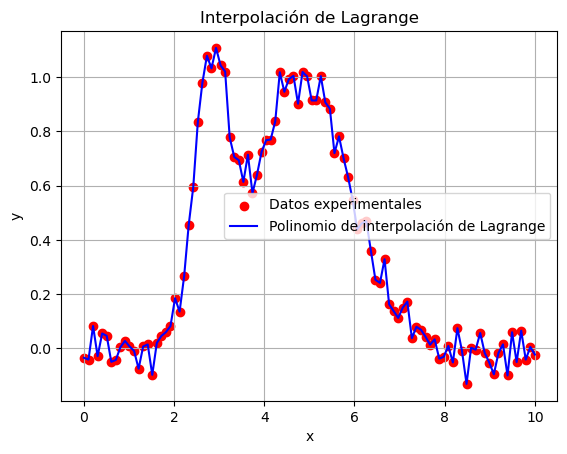

In [4]:
def lagrange_basis(x, x_data_l, k):
    """ Calcula la base de Lagrange L_k(x). """
    basis = 1
    for i in range(len(x_data_l)):
        if i != k:
            basis *= (x - x_data_l[i]) / (x_data_l[k] - x_data_l[i])
    return basis

def lagrange_interpolation(x_data_l, y_data_l, x):
    """ Calcula el polinomio de interpolación de Lagrange en x. """
    n = len(x_data_l)
    result = 0
    for k in range(n):
        result += y_data_l[k] * lagrange_basis(x, x_data_l, k)
    return result

# Cargar los datos
data = np.loadtxt("Datos_Taller_2B.txt")
x_data, y_data = data[:, 0], data[:, 1]

# Puntos para la evaluación del polinomio
x_vals_l = np.linspace(0, 10, 100)
y_vals_l = [lagrange_interpolation(x_data, y_data, x) for x in x_vals_l]

# Graficar
plt.scatter(x_data, y_data, color='red', label='Datos experimentales')
plt.plot(x_vals_l, y_vals_l, label='Polinomio de interpolación de Lagrange', color='blue')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Interpolación de Lagrange')
plt.grid()
plt.show()

## Splines cúbicos

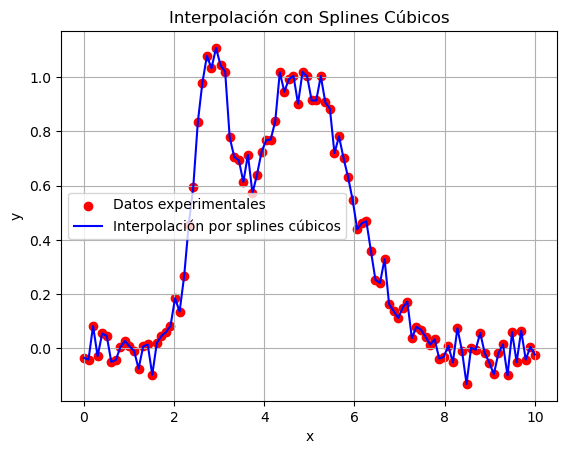

In [28]:
# Cargar los datos
data = np.loadtxt("Datos_Taller_2B.txt")
x_data, y_data = data[:, 0], data[:, 1]

# Calcular coeficientes del spline cúbico
coef = cubic_spline(x_data, y_data)

# Puntos para la evaluación del spline
x_vals = np.linspace(0, 10, 100)
y_vals = evaluate_spline(x_data, coef, x_vals)

# Graficar
plt.scatter(x_data, y_data, color='red', label='Datos experimentales')
plt.plot(x_vals, y_vals, label='Interpolación por splines cúbicos', color='blue')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Interpolación con Splines Cúbicos')
plt.grid()
plt.show()